# Post #3 — Simulation notebook
## Uncertainty vs. Accuracy: Same mean, radically different business outcomes

This notebook supports **Post #3** ("Why Uncertainty Matters More Than Accuracy") with a minimal, reproducible simulation.

**Idea:** Two demand regimes have the **same mean** (and thus the same point forecast), but **different variance**.  
We apply the *same* inventory policy to both and compare business KPIs.

What you should see:
- Holding costs may look similar (giving a false sense of stability)
- Stockout-related costs can blow up under higher variance — **even if point accuracy is unchanged**


In [1]:
import numpy as np
import pandas as pd


## 1) Parameters

We use a deliberately simple “base-stock” policy:
- At the start of each period, inventory is replenished up to a fixed level `base_stock`
- Demand is realized
- Anything not met is a stockout (penalized)

This is not meant to be a perfect OR model — it's a controlled demonstration.


In [2]:
rng = np.random.default_rng(42)

# Demand regimes
mu = 100
sigma_low = 10
sigma_high = 50

n_periods = 10_000

# Simple cost model (toy, but directionally correct)
holding_cost_per_unit_per_period = 0.02
stockout_penalty_per_unit = 5.0

# Base-stock policy (chosen "reasonably" for the low-variance regime)
safety_stock = 20
base_stock = mu + safety_stock

(mu, sigma_low, sigma_high, base_stock)


(100, 10, 50, 120)

## 2) Simulation function

Returns average per-period costs:
- holding cost (inventory sitting on shelves)
- stockout cost (unmet demand penalty)


In [3]:
def simulate_base_stock(demand: np.ndarray, base_stock: float) -> dict:
    inventory = float(base_stock)
    holding_cost = 0.0
    stockout_cost = 0.0

    for d in demand:
        d = float(d)
        stockout_units = max(d - inventory, 0.0)

        holding_cost += inventory * holding_cost_per_unit_per_period
        stockout_cost += stockout_units * stockout_penalty_per_unit

        # Replenish to base-stock for the next period
        inventory = float(base_stock)

    return {
        "avg_holding_cost": holding_cost / len(demand),
        "avg_stockout_cost": stockout_cost / len(demand),
        "avg_total_cost": (holding_cost + stockout_cost) / len(demand),
    }


## 3) Run the two regimes

We clip demand at 0 to avoid negative draws from the Normal distribution.


In [4]:
demand_low = np.maximum(0, rng.normal(mu, sigma_low, n_periods))
demand_high = np.maximum(0, rng.normal(mu, sigma_high, n_periods))

res_low = simulate_base_stock(demand_low, base_stock)
res_high = simulate_base_stock(demand_high, base_stock)

df = pd.DataFrame(
    [res_low, res_high],
    index=["Low variance demand", "High variance demand"]
)
df


,avg_holding_cost,avg_stockout_cost,avg_total_cost
Low variance demand,2.4,0.442764,2.842764
High variance demand,2.4,60.100600,62.500600


### Quick comparison

The “shock” in this example is that:
- the policy is the same
- the mean is the same
- but stockout costs can increase by *orders of magnitude* under higher variance

This is why **point forecasts** are often insufficient for operational decision systems.


In [ ]:
ratio = df.loc["High variance demand", "avg_stockout_cost"] / df.loc["Low variance demand", "avg_stockout_cost"] # type: ignore
ratio


np.float64(135.73950388077893)

## 4) What if we tune base-stock by variance?

A common reaction is: *“Well, you should set different order levels based on variance.”*

Yes — that is the point. Uncertainty has to be **estimated** and **propagated** into policy.
Here we show that raising `base_stock` reduces stockout cost for the high-variance case, at the expense of higher holding cost.


In [6]:
def sweep_base_stock(demand: np.ndarray, base_stocks: np.ndarray) -> pd.DataFrame:
    rows = []
    for bs in base_stocks:
        out = simulate_base_stock(demand, float(bs))
        rows.append({"base_stock": float(bs), **out})
    return pd.DataFrame(rows)

base_stocks = np.arange(110, 201, 10)  # 110..200
sweep_high = sweep_base_stock(demand_high, base_stocks)
sweep_high


,base_stock,avg_holding_cost,avg_stockout_cost,avg_total_cost
0,110.0,2.2,79.477014,81.677014
1,120.0,2.4,60.100600,62.500600
2,130.0,2.6,44.474508,47.074508
3,140.0,2.8,32.026284,34.826284
4,150.0,3.0,22.365087,25.365087
5,160.0,3.2,15.064686,18.264686
6,170.0,3.4,9.806515,13.206515
7,180.0,3.6,6.171605,9.771605
8,190.0,3.8,3.689018,7.489018
9,200.0,4.0,2.093797,6.093797


### Minimal plot (total cost vs base-stock)

We avoid fancy styling on purpose.


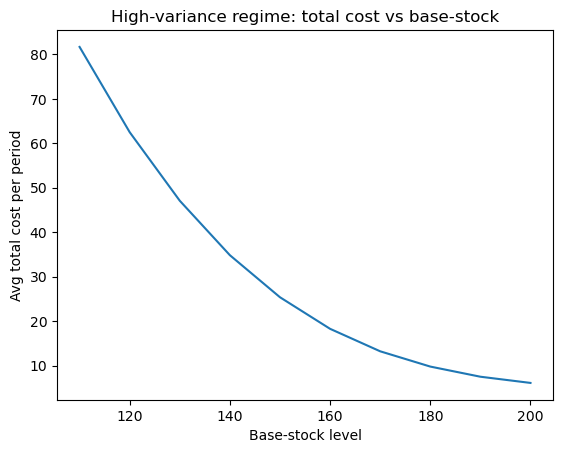

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sweep_high["base_stock"], sweep_high["avg_total_cost"])
plt.xlabel("Base-stock level")
plt.ylabel("Avg total cost per period")
plt.title("High-variance regime: total cost vs base-stock")
plt.show()


## Takeaway

If you only optimize for point accuracy, you can build systems that look stable while systematically underestimating risk.

A more robust workflow is:
1) Start from decision KPIs (service level, cost, risk tolerance)  
2) Represent uncertainty (intervals, quantiles, ensembles, scenarios)  
3) Make policy reflect that uncertainty (buffers, reorder points, escalation rules)
